In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

# Models
from keras import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.layers import (Input, Embedding, Dropout, LSTM, Conv2D, MaxPool2D,
                          Dense, Activation, Reshape, Flatten, TimeDistributed)
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

[]

***

In [3]:
from utils.data import PATH_TO_DATA, GUIS_CODE, GUIS_SKETCH
from utils.data.image import get_preprocessed_img
from utils.data.sequence import tokenize_dsl_code
from utils.data.sets import (get_sketch_id_code_pair, init_sketch_id_code_map,
                             load_vocabulary, init_word2idx, init_idx2word)

***

In [4]:
demo_sketch_id = '00150311-A7AE-4804-8B7D-9273687B4FC0'

### Init Sketch to DSL Code map

In [5]:
sketch_id_code_map = init_sketch_id_code_map(GUIS_CODE)
print(sketch_id_code_map[demo_sketch_id])

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



### Load / Show the Sketch

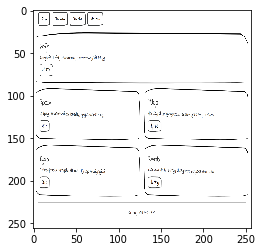

In [6]:
image = get_preprocessed_img(PATH_TO_DATA+demo_sketch_id+'.png')
plt.imshow(image);

***

## Create a Vocabulary

In [7]:
vocabulary = load_vocabulary('../vocabulary.txt')

In [8]:
len(vocabulary)

18

### Word2Idx, Idx2Word maps

In [9]:
word2idx = init_word2idx(vocabulary)
idx2word = init_idx2word(vocabulary)

In [10]:
word2idx

{'0': 0,
 ',': 1,
 '{': 2,
 '}': 3,
 'small-title': 4,
 'text': 5,
 'quadruple': 6,
 'row': 7,
 'btn-inactive': 8,
 'btn-orange': 9,
 'btn-green': 10,
 'btn-red': 11,
 'double': 12,
 '<START>': 13,
 'header': 14,
 'btn-active': 15,
 '<END>': 16,
 'single': 17}

In [11]:
idx2word

{0: '0',
 1: ',',
 2: '{',
 3: '}',
 4: 'small-title',
 5: 'text',
 6: 'quadruple',
 7: 'row',
 8: 'btn-inactive',
 9: 'btn-orange',
 10: 'btn-green',
 11: 'btn-red',
 12: 'double',
 13: '<START>',
 14: 'header',
 15: 'btn-active',
 16: '<END>',
 17: 'single'}

***

## Max DSL Code Length

In [12]:
print('Total number of DSL Codes: {}'.format(len(sketch_id_code_map.values())))

Total number of DSL Codes: 1700


In [13]:
longets_code = max(
    sketch_id_code_map.values(), key=lambda x: len(tokenize_dsl_code(x)))

print('Longes code:')
print('=' * 30)
print()
print(longets_code)

Longes code:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}



In [14]:
max_code_length = len(tokenize_dsl_code(longets_code)) + 2

print('Max DSL Code Length: {}'.format(max_code_length))

Max DSL Code Length: 117


In [15]:
max_code_length = 117

***

## Train/Dev/Test split

In [16]:
len(sketch_id_code_map)

1700

In [17]:
SPLIT = (.8, .1, .1)

In [18]:
items = list(sketch_id_code_map.items())
total_num = len(items)

borders = (
    int(total_num * SPLIT[0]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]) + int(
        total_num * SPLIT[2]),
)

train_sketch_id_code_map = dict(items[0:borders[0]])
dev_sketch_id_code_map = dict(items[borders[0]:borders[1]])
test_sketch_id_code_map = dict(items[borders[1]:borders[2]])

In [19]:
assert len(train_sketch_id_code_map) + len(dev_sketch_id_code_map) + len(
    test_sketch_id_code_map) == len(sketch_id_code_map)

In [20]:
print('Train Set size: {}'.format(len(train_sketch_id_code_map)))
print('Dev Set size: {}'.format(len(dev_sketch_id_code_map)))
print('Test Set size: {}'.format(len(test_sketch_id_code_map)))

Train Set size: 1360
Dev Set size: 170
Test Set size: 170


***

## Data Generator

In [21]:
# data generator, intended to be used in a call to model.fit_generator()


def data_generator(sketch_id_code_set, word2idx, batch_size, maxlen=max_code_length):
    X_img = np.zeros((batch_size, 256, 256, 3))
    X_seq = []
    Y_seq = []
    n = 0

    # loop for ever over images
    while True:
        keys = list(sketch_id_code_set.keys())
        np.random.shuffle(keys)
        data_set = [(key, sketch_id_code_set[key]) for key in keys]
        
        for sketch_id, code in data_set:
            # load sketch
            sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')
            X_img[n] = sketch

            # encode the sequence
            y_seq = [word2idx[word] for word in tokenize_dsl_code(code)] + [word2idx['<END>']]
            x_seq = [word2idx['<START>']] + y_seq[:-1]

            Y_seq.append(y_seq)
            X_seq.append(x_seq)

            n += 1
            # yield the batch data
            if n == batch_size:
                X_seq = pad_sequences(X_seq, maxlen=maxlen, padding='post')
                Y_seq = pad_sequences(Y_seq, maxlen=maxlen, padding='post')

                # One-hot
                Y_seq = [[
                    to_categorical(idx, len(vocabulary)) for idx in sent
                ] for sent in Y_seq]

                yield [[X_img, X_seq], np.array(Y_seq)]

                X_img = np.zeros((batch_size, 256, 256, 3))
                X_seq = []
                Y_seq = []
                n = 0

***

In [22]:
EMBEDDING_DIM = 128
NUM_HIDDEN_NEURONS = [256, 256]

# Sketch Encoder (ConvNet)

In [23]:
img_in = Input((256, 256, 3), name='image_input')

x = Conv2D(32, (3, 3), activation='relu', padding='valid', name='conv_32_1')(img_in)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', name='conv_32_2')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_1')(x)
x = Dropout(0.3, name='conv_dropout_1')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv_64_1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv_64_2')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_2')(x)
x = Dropout(0.3, name='conv_dropout_2')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv_128_1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv_128_2')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_3')(x)
x = Dropout(0.3, name='conv_dropout_3')(x)

x = Flatten(name='flatten')(x)

x = Dense(1024, activation='relu', name='dense_relu_1')(x)
x = Dropout(0.3, name='dense_dropout_1')(x)

x = Dense(1024, activation='relu', name='dense_relu_2')(x)
x = Dropout(0.3, name='dense_dropout_2')(x)

x = Dense(EMBEDDING_DIM, activation='relu', name='dense_relu_encoder')(x)
x = Reshape((1, EMBEDDING_DIM), name='embedding_reshapor')(x)

sketch_encoder = Model(img_in, x, name='sketch_encoder')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
plot_model(sketch_encoder, to_file='./model_plots/look_once/sketch_encoder.png', show_shapes=True, show_layer_names=True)

print(sketch_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv_32_1 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv_32_2 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 126, 126, 32)      0         
_________________________________________________________________
conv_dropout_1 (Dropout)     (None, 126, 126, 32)      0         
_________________________________________________________________
conv_64_1 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
conv_64_2 (Conv2D)           (None, 122, 122, 64)      36928     
__________

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../img/LSTM.png)

In [25]:
# Sequence Input
seq_in = Input((max_code_length,), name='sequence_input')
sketch_emb_in = Input((1, EMBEDDING_DIM), name='sketch_emb_input')


# Embeddings
embeddings = Embedding(
    len(vocabulary),
    EMBEDDING_DIM,
    input_length=max_code_length,
    mask_zero=True,
    name='embeddings'
)
x = embeddings(seq_in)
    
# Dropout
embeddings_dropout = Dropout(0.3, name='embeddings_dropout')
x = embeddings_dropout(x)

# Sequence Decoder
lstm_decoder_1 = LSTM(NUM_HIDDEN_NEURONS[0], return_sequences=True, return_state=True, name='lstm_decoder_1')
lstm_decoder_2 = LSTM(NUM_HIDDEN_NEURONS[1], return_sequences=True, return_state=True, name='lstm_decoder_2')

# Get the context from the Sketch
_, h_state, c_state = lstm_decoder_1(sketch_emb_in)

# Generate code
x, _, _ = lstm_decoder_1(x, initial_state=[h_state, c_state])
x, _, _ = lstm_decoder_2(x)

# Dense -> Softmax
dense_decoder = TimeDistributed(Dense(len(vocabulary), name='dense_layer'), name='dense_decoder')
x = dense_decoder(x)
softmax_decoder = TimeDistributed(Activation('softmax', name='softmax_layer'), name='softmax_decoder')
x = softmax_decoder(x)

sequence_decoder = Model(inputs=[seq_in, sketch_emb_in], outputs=x, name='sequence_decoder')

In [27]:
plot_model(sequence_decoder, to_file='./model_plots/look_once/sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 117)          0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 117, 128)     2304        sequence_input[0][0]             
__________________________________________________________________________________________________
sketch_emb_input (InputLayer)   (None, 1, 128)       0                                            
__________________________________________________________________________________________________
lstm_decoder_1 (LSTM)           multiple             394240      sketch_emb_input[0][0]           
                                                                 embeddings_dropout[0][0]         
          

***

# Model

![NIC_model](../img/Model.png)

In [28]:
sketch_emb = sketch_encoder(img_in)
seq_out = sequence_decoder([seq_in, sketch_emb])

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=seq_out, name='model')


### Visualize the model

In [29]:
plot_model(model, to_file='./model_plots/look_once/model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 117)          0                                            
__________________________________________________________________________________________________
sketch_encoder (Model)          (None, 1, 128)       104229280   image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 117, 18)      926482      sequence_input[0][0]             
                                                                 sketch_encoder[1][0]             
Total para

***

# Inference

![LSTM_sampling](../img/Sampling.png)

In [30]:
def init_inference_decoder():
    h_state_input_1 = Input((NUM_HIDDEN_NEURONS[0],), name='h_state_input_1')
    c_state_input_1 = Input((NUM_HIDDEN_NEURONS[0],), name='c_state_input_1')
    h_state_input_2 = Input((NUM_HIDDEN_NEURONS[1],), name='h_state_input_2')
    c_state_input_2 = Input((NUM_HIDDEN_NEURONS[1],), name='c_state_input_2')

    embedded_seq = embeddings(seq_in)
    embedded_seq = embeddings_dropout(embedded_seq)

    output_tokens, h_state_1, c_state_1 = lstm_decoder_1(
        embedded_seq, initial_state=[h_state_input_1, c_state_input_1])
    output_tokens, h_state_2, c_state_2 = lstm_decoder_2(
        output_tokens, initial_state=[h_state_input_2, c_state_input_2])

    output_tokens = dense_decoder(output_tokens)
    output_tokens = softmax_decoder(output_tokens)

    inference_decoder = Model(
        [seq_in,
         h_state_input_1, c_state_input_1,
         h_state_input_2, c_state_input_2],
        
        [output_tokens,
         h_state_1, c_state_1,
         h_state_2, c_state_2]
    )

    return inference_decoder


def get_sketch_embedding(sketch):
    return sketch_encoder.predict(np.expand_dims(sketch, 0))


def get_initial_lstm_states(sketch):
    states_model = Model(sketch_emb_in, lstm_decoder_1(sketch_emb_in)[1:])
    sketch_emb = get_sketch_embedding(sketch)
    states = states_model.predict(sketch_emb)
    return states + [np.zeros((1, NUM_HIDDEN_NEURONS[1]))]*2


def greedy_search_inference(sketch, maxlen=max_code_length):
    inference_decoder = init_inference_decoder()
    
    # Get the context of the Sketch
    states_values = get_initial_lstm_states(sketch)

    target_seq = np.zeros((1, maxlen))
    target_seq[0, 0] = word2idx['<START>']

    stop_condition = False
    decoded_tokens = []

    while not stop_condition:
        [output_tokens,
         h_state_1, c_state_1,
         h_state_2, c_state_2] = inference_decoder.predict(
            [target_seq] + states_values)
            
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = idx2word[sampled_token_index]

        if sampled_word == '{':
            decoded_tokens.append(' ')
            decoded_tokens.append(sampled_word)
            decoded_tokens.append('\n')

        elif sampled_word == '}':
            if idx2word[target_seq[0, 0]] != '}':
                decoded_tokens.append('\n')
            decoded_tokens.append(sampled_word)
            decoded_tokens.append('\n')

        elif sampled_word == ',':
            decoded_tokens.append(sampled_word)
            decoded_tokens.append(' ')

        else:
            decoded_tokens.append(sampled_word)

        # Exit condition
        if sampled_word == '<END>' or len(decoded_tokens) > maxlen*3:
            stop_condition = True

        target_seq = np.zeros((1, maxlen))
        target_seq[0, 0] = sampled_token_index

        states_values = [h_state_1, c_state_1, h_state_2, c_state_2]
    
    if '<END>' in decoded_tokens:
        decoded_tokens.remove('<END>')
    
    return ''.join(decoded_tokens)

***

## Run Train

### Callbacks

In [31]:
filepath="weights/look-once-weights.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=True)

def on_epoch_end(epoch, logs):
    if epoch % 5 == 0:
        print()
        print('Sampled:')
        print('='*30)
        print(greedy_search_inference(get_preprocessed_img(
            PATH_TO_DATA+np.random.choice(list(dev_sketch_id_code_map.keys()))+'.png'
        )))
        print()
        print()

lambda_cb = LambdaCallback(on_epoch_end=on_epoch_end)

callbacks = [checkpoint, lambda_cb]

In [32]:
model.load_weights('./weights/look-once-weights.hdf5')

model.compile(RMSprop(0.0001), loss='categorical_crossentropy')

In [40]:
batch_size = 64
steps = len(train_sketch_id_code_map) // batch_size

model.fit_generator(
    data_generator(train_sketch_id_code_map, word2idx, batch_size),
    steps_per_epoch=steps,
    epochs=100,
    verbose=True,
    callbacks=callbacks,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
21/21 [==============================] - 44s 2s/step - loss: 2.5582

Epoch 00001: saving model to weights/look-once-weights.hdf5


/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_decoder_1 was passed non-serializable keyword arguments: {'mask': [<tf.Tensor 'sequence_decoder/embeddings/NotEqual:0' shape=(?, 117) dtype=bool>, None, None], 'initial_state': [<tf.Tensor 'lstm_decoder_1/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_decoder_1/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '



Sampled:
btn-inactive btn-inactive btn-inactive btn-inactive btn-inactive btn-inactive , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,


Epoch 2/100
21/21 [==============================] - 27s 1s/step - loss: 2.1211

Epoch 00002: saving model to weights/look-once-weights.hdf5
Epoch 3/100
21/21 [==============================] - 43s 2s/step - loss: 2.0650

Epoch 00003: saving model to weights/look-once-weights.hdf5
Epoch 4/100
21/21 [==============================] - 42s 2s/step - loss: 2.0323

Epoch 00004: saving model to weights/look-once-weights.hdf5
Epoch 5/100
21/21 [==============================] - 44s 2s/step - loss: 2.0074

Epoch 00005: saving model to weights/look-once-weights.hdf5
Epoch 6/100
21/21 [==============================] - 43s 2s/step - loss: 1.9893

Epoch 00006: saving model to weights/look-o

21/21 [==============================] - 33s 2s/step - loss: 0.3906

Epoch 00037: saving model to weights/look-once-weights.hdf5
Epoch 38/100
21/21 [==============================] - 43s 2s/step - loss: 0.3703

Epoch 00038: saving model to weights/look-once-weights.hdf5
Epoch 39/100
21/21 [==============================] - 45s 2s/step - loss: 0.3461

Epoch 00039: saving model to weights/look-once-weights.hdf5
Epoch 40/100
21/21 [==============================] - 45s 2s/step - loss: 0.3298

Epoch 00040: saving model to weights/look-once-weights.hdf5
Epoch 41/100
21/21 [==============================] - 43s 2s/step - loss: 0.3110

Epoch 00041: saving model to weights/look-once-weights.hdf5

Sampled:
header { btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { { { small-title , text , btn-orange } } row { { { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orang

21/21 [==============================] - 32s 2s/step - loss: 0.0736

Epoch 00072: saving model to weights/look-once-weights.hdf5
Epoch 73/100
21/21 [==============================] - 42s 2s/step - loss: 0.0733

Epoch 00073: saving model to weights/look-once-weights.hdf5
Epoch 74/100
21/21 [==============================] - 43s 2s/step - loss: 0.0711

Epoch 00074: saving model to weights/look-once-weights.hdf5
Epoch 75/100
21/21 [==============================] - 42s 2s/step - loss: 0.0716

Epoch 00075: saving model to weights/look-once-weights.hdf5
Epoch 76/100
21/21 [==============================] - 44s 2s/step - loss: 0.0683

Epoch 00076: saving model to weights/look-once-weights.hdf5

Sampled:
header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } } row { double { sm

***

## Dev

In [33]:
from nltk.translate import bleu_score

In [34]:
def evaluate(path_to_img=None, reference=None):
    if path_to_img is None:
        sketch_id = np.random.choice(list(dev_sketch_id_code_map.keys()))
        sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')
        reference = [dev_sketch_id_code_map[sketch_id]]
        
    else:
        sketch = get_preprocessed_img(path_to_img)

    hypothesis = greedy_search_inference(sketch)
    
    print('Greedy Search Hypothesis:')
    print('='*30)
    print()
    print(hypothesis)
    print(end='\n\n')
    
    print('Reference:')
    print('='*30)
    print()
    print(reference[0])
    print(end='\n\n')
    
    print('BLEU score: {}'.format(
        bleu_score.sentence_bleu(reference, hypothesis)
    ))
        
    plt.imshow(sketch);

Greedy Search Hypothesis:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



Reference:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



BLEU score: 1.0


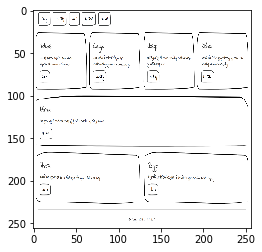

In [35]:
evaluate()

***

# Compilation

In [36]:
from compilers.web import Compiler

In [37]:
sketch_id = np.random.choice(list(test_sketch_id_code_map.keys()))
sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')

dsl_code = greedy_search_inference(sketch)
with open('./dsl_code.gui', 'w') as f:
    f.write(dsl_code)

In [38]:
web_compiler = Compiler(dsl_mapping_file_path='./compilers/web/dsl_mapping.json')
web_compiler.compile('./dsl_code.gui', './out.html')